In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class ModelTypes:
    LOG_REG = 'logistic_regression'
    LGBM = 'lightgbm'
    KNN = 'k-nearest_neighbors'
    XGB = 'xgboost'
    ANN = 'Rede neural'

ntd_brl = 0.072054

In [3]:
df = pd.read_csv('../data/raw/UCI_Credit_Card.csv', index_col='ID')
df = df.rename({'default.payment.next.month': 'default'}, axis=1)
df = df.rename(dict(
    ID='id',
    LIMIT_BAL= 'limite_credito', 
    SEX='sexo',
    EDUCATION='educacao',
    MARRIAGE='estado_civil',
    AGE='idade',
    PAY_0='status_pagamento_mes_09',
    PAY_2='status_pagamento_mes_08',
    PAY_3='status_pagamento_mes_07',
    PAY_4='status_pagamento_mes_06',
    PAY_5='status_pagamento_mes_05',
    PAY_6='status_pagamento_mes_04',
    BILL_AMT1='fatura_mes_09',
    BILL_AMT2='fatura_mes_08',
    BILL_AMT3='fatura_mes_07',
    BILL_AMT4='fatura_mes_06',
    BILL_AMT5='fatura_mes_05',
    BILL_AMT6='fatura_mes_04',
    PAY_AMT1='pago_mes_09',
    PAY_AMT2='pago_mes_08',
    PAY_AMT3='pago_mes_07',
    PAY_AMT4='pago_mes_06',
    PAY_AMT5='pago_mes_05',
    PAY_AMT6='pago_mes_04',
),axis=1)

df['sexo'] = df['sexo'].map({1: 'masculino', 2:'feminino'})
df['educacao'] = df['educacao'].map({0: 'outros/desconhecido', 1:'pos_graduacao', 2:'graduacao', 3:'ensino_medio', 4: 'outros/desconhecido', 5: 'outros/desconhecido', 6: 'outros/desconhecido'})
df['estado_civil'] = df['estado_civil'].map({1: 'casado', 2: 'solteiro', 3: 'outros/desconhecido', 0: 'outros/desconhecido'})

for col in df.columns:
    if ('fatura_mes' in col) or ('pago_mes' in col) or (col == 'limite_credito'):
        df[col] = (df[col] * ntd_brl).round(2)

In [4]:
assert df.isna().sum().sum() == 0

In [5]:
df[df[[col for col in df.columns if 'status' in col]].sum(axis=1) <= -6].iloc[0]

limite_credito                  1441.08
sexo                          masculino
educacao                   ensino_medio
estado_civil                   solteiro
idade                                35
status_pagamento_mes_09              -2
status_pagamento_mes_08              -2
status_pagamento_mes_07              -2
status_pagamento_mes_06              -2
status_pagamento_mes_05              -1
status_pagamento_mes_04              -1
fatura_mes_09                       0.0
fatura_mes_08                       0.0
fatura_mes_07                       0.0
fatura_mes_06                       0.0
fatura_mes_05                    937.21
fatura_mes_04                   1002.42
pago_mes_09                         0.0
pago_mes_08                         0.0
pago_mes_07                         0.0
pago_mes_06                      937.21
pago_mes_05                       80.84
pago_mes_04                         0.0
default                               0
Name: 10, dtype: object

In [6]:
# pagamento_mes_*: -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)

**Significado das variáveis**

`status_pagamento_mes_*`:
Ref: [aqui](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608), [aqui](https://danyele.github.io/lecture_notes/ReportGroup1.pdf)
* −2: não foi usado crédito para aquele mês; última fatura paga corretamente
* −1: consumo normal de crédito; última fatura paga corretamente
* 0:  uso de crédito rotativo (i.e. fatura foi paga parcialmente)
* 1-9: atraso de X meses no pagamento


**Feature engineering**:
> Ref: https://www.kaggle.com/code/fegadeharish/eda-and-logistic-regression

 * Construir variáveis de médias? Usar id?
 * "Married people between age bracket of 30 and 50 and unmarried clients of age 20-30 tend to default payment with unmarried clients higher probability to default payment.

* É justo usar variável de "sexo"? E "idade"? 
    * "females of age group 20-30 have very high tendency to default payment compared to males in all age brackets"

-- TODO: definir quais variáveis categóricas vamos deixar como texto, **ou** aplicar um encoder para todas automaticamente


In [7]:
import shap
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from category_encoders import WOEEncoder
from betacal import BetaCalibration

class AutoWOEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.woe_encoder = None
        self.categorical_features = None
    
    def fit(self, X, y=None):
        # Identify categorical columns
        self.categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        self.woe_encoder = WOEEncoder(cols=self.categorical_features)
        self.woe_encoder.fit(X, y)
        return self
    
    def transform(self, X):
        return self.woe_encoder.transform(X)
    

class BetaCalibratedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None):
        self.base_estimator = base_estimator or LogisticRegression()
        self.beta_calibrator = BetaCalibration()
        
    def fit(self, X, y):
        
        self.base_estimator.fit(X, y)
        probs = self.base_estimator.predict_proba(X)[:, 1] 
        self.beta_calibrator.fit(probs, y) # uses train set predictions to calibrate -- not ideal
        return self
    
    def predict(self, X):
        probs = self.base_estimator.predict_proba(X)[:, 1]
        calibrated_probs = self.beta_calibrator.predict(probs)
        return calibrated_probs >= 0.5
    
    def predict_proba(self, X):
        probs = self.base_estimator.predict_proba(X)[:, 1]
        calibrated_probs = self.beta_calibrator.predict(probs)
        return np.vstack((1-calibrated_probs, calibrated_probs)).T

In [19]:
# for col in df.columns:
#     if 'status_pagamento' in col:
#         df[col] = df[col].replace(-2, 0)

In [9]:
# X, y = df.drop('default', axis=1), df['default']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=123, stratify=df['default'])

In [21]:
# df_train.to_excel('dados/processed/InteliBank_Inadimplencia_de_credito__Treino.xlsx')

# df_test_copy = df_test.copy()
# df_test_copy['default'] = np.nan
# df_test_copy['score'] = np.nan

# df_test_copy.to_excel('dados/processed/InteliBank_Inadimplencia_de_credito__Avaliacao.xlsx')


In [11]:
X_train, y_train = df_train.drop('default', axis=1), df_train['default']
X_test, y_test = df_test.drop('default', axis=1), df_test['default']

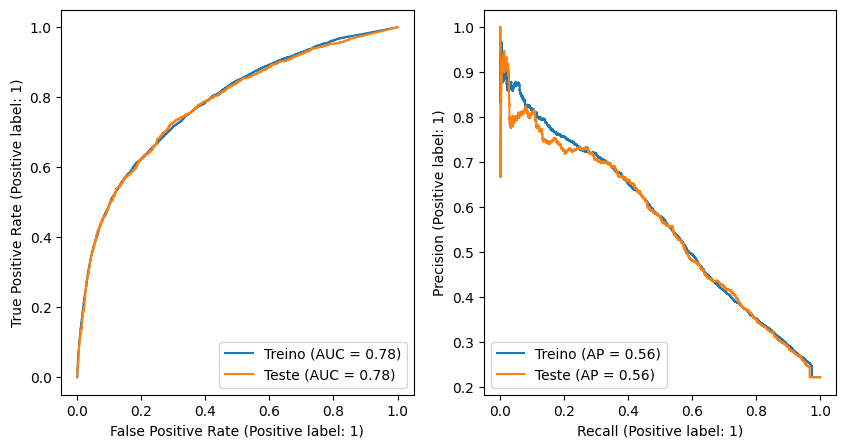

In [25]:
model_choice = ModelTypes.ANN

match model_choice:
    case ModelTypes.LOG_REG:
        base_model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.01, solver='liblinear')

    case ModelTypes.LGBM:
        from lightgbm import LGBMClassifier
        base_model = LGBMClassifier(n_estimators=300, learning_rate=0.007, reg_alpha=0.5, reg_lambda=0.5,  random_state=123)
        # model = LGBMClassifier(n_estimators=125, learning_rate=0.08, colsample_bytree=0.9, min_child_weight=1, subsample=0.8)

    case ModelTypes.KNN:
        from sklearn.neighbors import KNeighborsClassifier
        base_model = KNeighborsClassifier(n_neighbors=300, weights='uniform', n_jobs=3)

    case ModelTypes.XGB:
        from xgboost import XGBClassifier
        # https://analytics-nuts.github.io/Comparative-Study-of-Classification-Techniques-on-Credit-Defaults/
        base_model = XGBClassifier(learning_rate=0.08, n_estimators=125, max_depth=6, colsample_bytree=0.9,gamma=0.5,
                                min_child_weight=1,subsample=0.8)
        
    case ModelTypes.ANN:
        from sklearn.neural_network import MLPClassifier
        base_model = MLPClassifier((4, 8, 4), random_state=123)
    
    case _:
        print("No model selected!")
        base_model = None

pipe = Pipeline([
    ('auto_woe_encoder', AutoWOEEncoder()),  
    ('scaler', StandardScaler().set_output(transform="pandas")),
    ('beta_calibrated_classifier', BetaCalibratedClassifier(base_estimator=base_model)) 
])
pipe.fit(X_train, y_train)

y_probs_train = pipe.predict_proba(X_train)[:,1]
y_probs_test = pipe.predict_proba(X_test)[:,1]

fig, ax = plt.subplots(figsize=(10,5),ncols=2)
RocCurveDisplay.from_predictions(y_train, y_probs_train, ax=ax[0], name='Treino')
RocCurveDisplay.from_predictions(y_test, y_probs_test, ax=ax[0], name='Teste')

PrecisionRecallDisplay.from_predictions(y_train, y_probs_train, ax=ax[1], name='Treino')
PrecisionRecallDisplay.from_predictions(y_test, y_probs_test, ax=ax[1], name='Teste');


In [26]:
if model_choice == ModelTypes.LGBM:
    coefs = pipe['beta_calibrated_classifier'].base_estimator.coef_
    aux = pd.DataFrame({'var': X_train.columns, 'coef': coefs[0]}).sort_values('coef', ascending=True).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(5,6))
    ax.barh(aux.index, aux['coef'])
    ax.set_yticks(aux.index, aux['var'])
    ax.set_title('Coeficientes da regressão logística')
    # ax.set_facecolor('#0C1017')
    ax.grid()
    plt.show()

if model_choice in (ModelTypes.LGBM, ModelTypes.XGB):
    clf = pipe['beta_calibrated_classifier'].base_estimator
    mini_pipeline = make_pipeline(pipe['auto_woe_encoder'], pipe['scaler'])
    X_test_ = mini_pipeline.transform(X_test)
    # X_train_ = mini_pipeline.transform(X_train)

    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test_)

    if model_choice == ModelTypes.LGBM:
        shap.summary_plot(shap_values[0], X_test_, feature_names=X_train.columns, max_display=10)
    
    if model_choice == ModelTypes.XGB:
        shap.summary_plot(shap_values, X_test_, feature_names=X_train.columns, max_display=10)

# if model_choice == ModelTypes.KNN:
#     clf = pipe['beta_calibrated_classifier'].base_estimator
#     mini_pipeline = make_pipeline(pipe['auto_woe_encoder'], pipe['scaler'])
    
#     X_train_ = shap.utils.sample(X_train, 500)
#     X_train_ = mini_pipeline.transform(X_train_)

#     X_test_ = shap.utils.sample(X_test_, 500)
#     X_test_ = mini_pipeline.transform(X_test_)
    
#     explainer = explainer = shap.KernelExplainer(clf.predict_proba, X_train_,)
#     shap_values = explainer.shap_values(X_test_)

In [27]:
fig = plt.figure()
shap.summary_plot(shap_values, X_test_, feature_names=X_train.columns, max_display=15, show=False)
plt.gcf().set_size_inches(8,6)
plt.show()


NameError: name 'shap_values' is not defined

<Figure size 640x480 with 0 Axes>

# Definindo política de crédito

In [28]:
# se quiser exportar 
y_pred = pipe.predict_proba(X_test)[:,1]
out = X_test.copy()
out['Prediction'] = y_pred
out.to_excel('output_ann.xlsx')

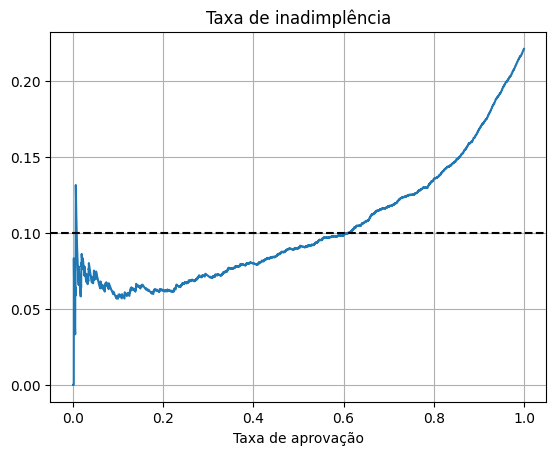

In [29]:
# assumindo X_test e y_test dados
scores = pipe.predict_proba(X_test)[:,1]
policy_df = pd.DataFrame({'score': scores, 'default': y_test}).sort_values('score', ascending=True).reset_index(drop=True)

# construir taxa de inadimplência ao dividir a inadimplência total pelo total de indivíduos
policy_df['taxa_inadimp'] = policy_df['default'].cumsum()/(policy_df.index + 1)
policy_df['taxa_aprovacao'] = policy_df.index/len(policy_df)

fig, ax = plt.subplots()
plt.plot(policy_df['taxa_aprovacao'], policy_df['taxa_inadimp'])
plt.title("Taxa de inadimplência")
plt.xlabel("Taxa de aprovação")
plt.axhline(0.1, color='black', linestyle='--')
plt.grid()

In [30]:
# remove the beginning of the curve
aux = policy_df.iloc[30:]

In [31]:
best = aux.iloc[(aux['taxa_inadimp']-0.1).abs().argsort()].iloc[0]
score = best.score
taxa_aprov = best.taxa_aprovacao

print(score)
print(taxa_aprov)

0.17488505702815813
0.6115


In [32]:
print(f"Lucro por aprovacao: {500 * taxa_aprov * 0.9 - 300 * taxa_aprov * 0.1:.2f}")

Lucro por aprovacao: 256.83
